<a href="https://colab.research.google.com/github/juliorodrigues07/manuscript_digit_recognition/blob/tuning/notebooks/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DNN and CNN for Manuscript Digit Recognition**

##[Table of Contents](#scrollTo=ZWjwmu48STPc)

>[Imports and Export Directories](#scrollTo=93DT3HrxkSUL)

>[1. Initial Configurations](#scrollTo=uTG8EXyaM8kx)

>[2. Preprocessing](#scrollTo=RYNQUiCBjlfs)

>[3. Data Visualization](#scrollTo=mfJY4pR2hBwQ)

>[4. Training Models](#scrollTo=fQXlJ_IevXRx)

>>[4.1. DNN - Deep Neural Network](#scrollTo=OErx9rlhU9QV)

>>[4.2. CNN - Convolutional Neural Network](#scrollTo=nz_9iWQWW1DJ)

>[5. Predicting Instances](#scrollTo=QGQ2gyMkDIzq)

>>[5.1. Confusion Matrix](#scrollTo=5woCv7GyVv7A)

>>[5.2. Classifying Own Images](#scrollTo=s8TDQ7Oo-90V)

>[6. Saving Models](#scrollTo=XZfAkrTXbG7j)



# **Imports and Export Directories**

In [1]:
from os.path import isdir
from os      import getcwd
from os      import mkdir


if not isdir(f'{getcwd()}/../models'):
    mkdir(f'{getcwd()}/../models')
if not isdir(f'{getcwd()}/../plots'):
    mkdir(f'{getcwd()}/../plots')
if not isdir(f'{getcwd()}/../datasets'):
    mkdir(f'{getcwd()}/../datasets')
if not isdir(f'{getcwd()}/../datasets/digits'):
    mkdir(f'{getcwd()}/../datasets/digits')

# **1. Defining Initial Configurations and HyperParameters**

- Due to not offering support to the F1 metric (Macro F1 - Harmonic mean between precision and recall), we'll develop a custom implementation of it to evaluate the models' performances;
- Macro F1 doesn't consider class imbalance in calculation (unweighted), which tends to present lower values compared to Micro F1 with imbalanced datasets;
- In general, using the Macro F1 is better for evaluating a model, since a low accuracy with labels that correspond to minority classes will have the same impact as the majority ones on the final result;
- For instance, considering a binary classification problem (yes or no) with 80% of instances from the class _yes_ and 20% from the class _no_, a model that has a high accuracy predicting instances from _yes_ class and, in the other hand, extremely low results with _no_ class, tends to mask the results with Micro F1 (global accuracy with true/false positives and true/false negatives);
- The Macro F1 calculates accuracy scores for each classes before outputing the global result, making it more reliable to evaluate a model's performance visualing its scores for each class and the final unweighted mean.

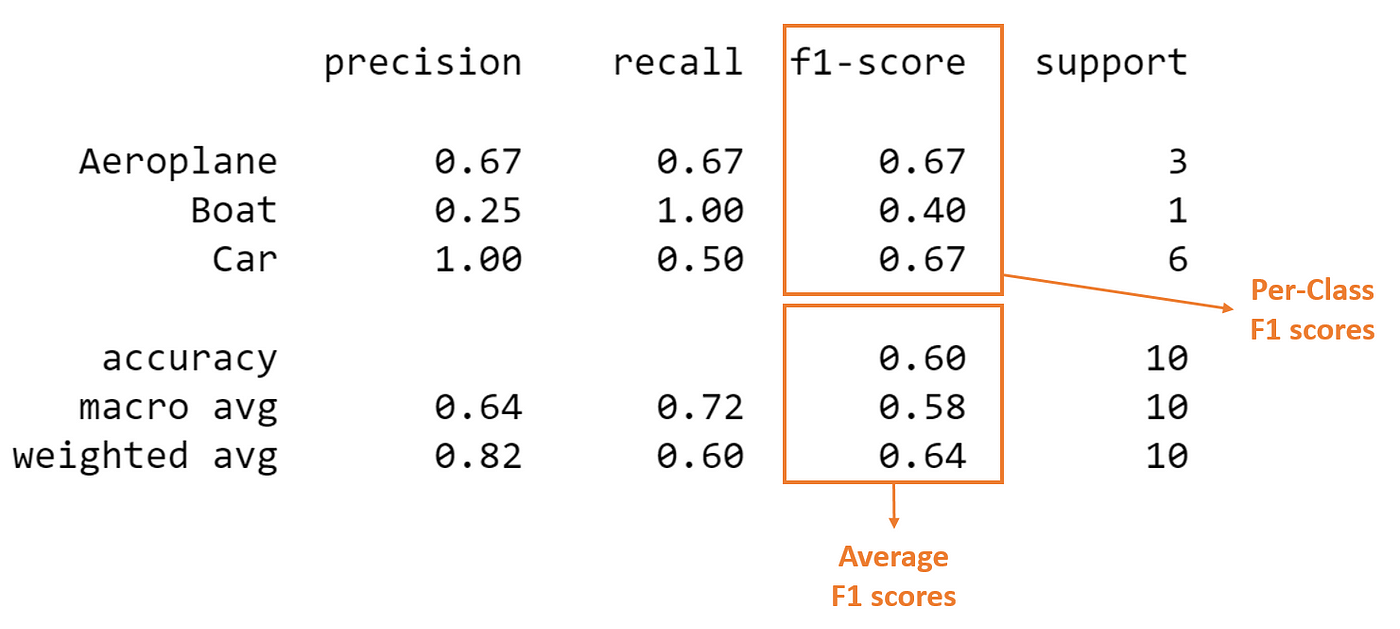

In [2]:
from keras import backend


def f1_score(ground_truth, prediction):

    def recall(ground_truth, prediction):
        '''Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        '''
        true_positives = backend.sum(backend.round(backend.clip(ground_truth * prediction, 0, 1)))
        possible_positives = backend.sum(backend.round(backend.clip(ground_truth, 0, 1)))
        recall = true_positives / (possible_positives + backend.epsilon())
        return recall

    def precision(ground_truth, prediction):
        '''Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        '''
        true_positives = backend.sum(backend.round(backend.clip(ground_truth * prediction, 0, 1)))
        predicted_positives = backend.sum(backend.round(backend.clip(prediction, 0, 1)))
        precision = true_positives / (predicted_positives + backend.epsilon())
        return precision

    precision = precision(ground_truth, prediction)
    recall = recall(ground_truth, prediction)

    return 2 * ((precision * recall) / (precision + recall + backend.epsilon()))

In [3]:
# Optimizer ('SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl')
opt = 'Adam'

# Loss (Multilabel classification)
lss = 'categorical_crossentropy'

# Activation functions ('relu', 'sigmoid', 'softplus', 'softsign', 'softmax', 'tanh', 'selu', 'elu', 'exponential')
actv_funct = 'relu'
exit_actv_funct = 'softmax'

# Batch size and number of epochs for training
b_size = 60
n_epochs = 4

# **2. Preprocessing**

- Since images are fundamentally matrices, we need to apply some transformation with that data to fit it to the NN input and possibly speed up its convergence;
- The whole dataset consists just of images, all which resolution is 28x28;
- We'll reshape this matrices to assume an array format (flattenning) of length 784 (28 * 28 = 784);
- Then, we'll compress the pixel values (0 to 255) into a new range from 0 to 1, which possibly will make the NNs converge faster.

In [4]:
from tensorflow import keras
from keras      import datasets
import numpy as np


# Number of target labels (Digits from 0 to 9)
n_classes = 10

# Holdout split of the dataset (train and test)
(raw_training_attributes, raw_training_classes), (raw_test_attributes, raw_test_classes) = datasets.mnist.load_data()

# Discretizes the target labels
training_classes = keras.utils.to_categorical(raw_training_classes, n_classes)
test_classes = keras.utils.to_categorical(raw_test_classes, n_classes)

# Converts an image (matrix) with 28 x 28 resolution to an array of size 784
reshaped_training = raw_training_attributes.reshape(60000, 784)
reshaped_test = raw_test_attributes.reshape(10000, 784)

# Normalizes the pixel values (0 to 255) between 0 and 1 (features)
training_attributes = reshaped_training.astype('float32') / 255
test_attributes = reshaped_test.astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


# **3. Data Visualization**

- Plotting a grid of sample images from the dataset.

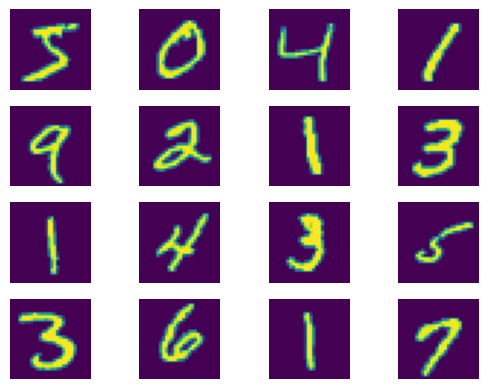

In [5]:
import matplotlib.pyplot as plt
import math


size = 16
sqrt_size = int(math.sqrt(size))

plt.figure()

for i in range(size):
  plt.subplot(sqrt_size, sqrt_size, i + 1)
  plt.imshow(raw_training_attributes[i])
  plt.axis('off')

plt.show()

# **4. Training the Models**



## **4.1. DNN - Deep Neural Network**


In [6]:
from keras import layers


# Defining the structure of the NN (number of layers, neurons, activation...)
dnn_model = keras.Sequential([
                          layers.Dense(784, activation=actv_funct, input_dim=training_attributes.shape[1]),
                          layers.Dense(260, activation=actv_funct),
                          layers.Dense(130, activation=actv_funct),
                          layers.Dense(n_classes, activation=exit_actv_funct)
])

# NN summary and its training
dnn_model.summary()
dnn_model.compile(loss=lss, optimizer=opt, metrics=[f1_score])
dnn_model.fit(training_attributes, training_classes, batch_size=b_size, epochs=n_epochs, verbose=1)

# Model's performance
dnn_results = dnn_model.evaluate(test_attributes, test_classes, verbose=0)
print(f'\nLoss:      {str(round(dnn_results[0] * 100, 2))}%')
print(f'F1 Score: {str(round(dnn_results[1] * 100, 2))}%')

dnn_model.save(f'{getcwd()}/../models/DNN_tmp.keras')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 260)               204100    
                                                                 
 dense_2 (Dense)             (None, 130)               33930     
                                                                 
 dense_3 (Dense)             (None, 10)                1310      
                                                                 
Total params: 854780 (3.26 MB)
Trainable params: 854780 (3.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/4
1000/1000 [==============================] - 8s 3ms/step - loss: 0.1969 - f1_score: 0.9369
Epoch 2/4
1000/1000 [==============================

## **4.2. CNN - Convolutional Neural Network**

In [11]:
import tensorflow as tf


cnn_model = keras.Sequential()

# First convolutional layer
cnn_model.add(layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same', activation=actv_funct, input_shape=(28, 28, 1)))
cnn_model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Second convolutional layer
cnn_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation=actv_funct))
cnn_model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Dropout layer (Randomly resets connection weights at each N training steps to reduce overfitting)
cnn_model.add(layers.Dropout(0.25))
cnn_model.add(layers.Flatten())

# Two hidden layers completely connected
cnn_model.add(layers.Dense(128, activation=actv_funct))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(10, activation=tf.nn.softmax))

# Data resizing, adapting to CNN utilization
cnn_training_attributes = training_attributes.reshape(60000, 28, 28, 1)
cnn_test_attributes = test_attributes.reshape(10000, 28, 28, 1)

# CNN training
# cnn_model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
cnn_model.compile(optimizer=opt, loss=lss, metrics=[f1_score])
cnn_model.fit(cnn_training_attributes, training_classes, epochs=n_epochs, batch_size=b_size)

# Model's performance
cnn_results = cnn_model.evaluate(cnn_test_attributes, test_classes, verbose=0)
print(f'\nLoss:      {str(round(cnn_results[0] * 100, 2))}%')
print(f'F1 Score: {str(round(cnn_results[1] * 100, 2))}%')

cnn_model.save(f'{getcwd()}/../models/CNN_tmp.keras')

Epoch 1/4
1000/1000 [==============================] - 6s 4ms/step - loss: 0.2276 - f1_score: 0.9230
Epoch 2/4
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0840 - f1_score: 0.9755
Epoch 3/4
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0639 - f1_score: 0.9812
Epoch 4/4
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0522 - f1_score: 0.9844

Loss:      2.44%
F1 Score: 99.14%


# **5. Predicting Instances and Analyzing Results**

In [9]:
def visualize_predictions(attributes, n, c_map, model):

    final = np.argmax(model.predict(attributes[0 : n]), axis=-1)

    fig, ax = plt.subplots(nrows=math.ceil(n / 5), ncols=5)
    ax = ax.flatten()

    print(f'Predictions for the first {n} images:')

    for i in range(n):
        print(final[i], end=' | ')

        if int((i + 1) % 5) == 0:
            print('\t')

        img = attributes[i].reshape((28, 28))
        plt.axis("off")

        ax[i].imshow(img, cmap=c_map, interpolation='nearest')
        ax[i].axis("off")

    print(f'\nFirst {n} from the test set:')

In [10]:
from keras.models import load_model


# file_name = f'{getcwd()}/../models/CNN_{str(n_epochs)}_{str(b_size)}_{str(actv_funct)}_{str(exit_actv_funct)}_{str(opt)}_{str(lss)}.keras'
file_name = f'{getcwd()}/../models/CNN_tmp.keras'

loaded_model = load_model(file_name)
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)             

1/1 [==============================] - 0s 177ms/step
Predictions for the first 25 images:
7 | 2 | 1 | 0 | 4 | 	
1 | 4 | 9 | 5 | 9 | 	
0 | 6 | 9 | 0 | 1 | 	
5 | 9 | 7 | 3 | 4 | 	
9 | 6 | 6 | 5 | 4 | 	

First 25 from the test set:


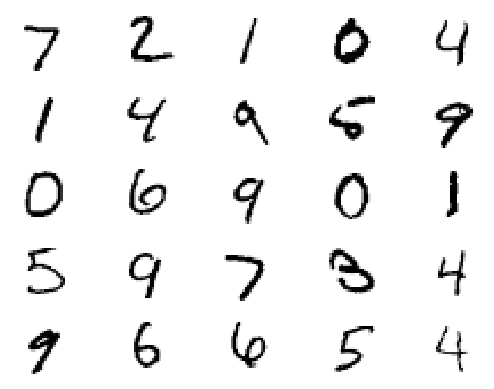

In [12]:
visualize_predictions(cnn_test_attributes, 25, 'Greys', loaded_model)

## **5.1. Confusion Matrix**


313/313 [==============================] - 1s 2ms/step


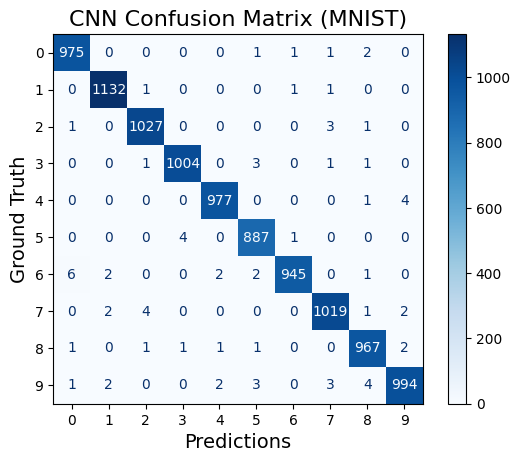

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay


# Executes predictions
final = np.argmax(loaded_model.predict(cnn_test_attributes), axis=-1)

# Formats the data from ground truth to compare with predictions
cnn_test_classes = list()
for i in range(len(test_classes)):
  cnn_test_classes.append(np.argmax(test_classes[i]))

# Labels' names (Digits from 0 to 9)
class_names = [str(i) for i in range(n_classes)]

# Confusion matrix graph plot
ConfusionMatrixDisplay.from_predictions(cnn_test_classes, final, display_labels=class_names, cmap='Blues')
plt.title('CNN Confusion Matrix (MNIST)', fontsize=16)
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Ground Truth', fontsize=14)

plt.savefig(f'{getcwd()}/../plots/confusion_matrix_cnn.svg', format='svg')
plt.show()

## **5.2. Classifying Own Images**

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
1/1 [==============================] - 0s 123ms/step
Predictions for the first 13 images:
3 | 3 | 3 | 3 | 3 | 	
3 | 3 | 3 | 3 | 3 | 	
3 | 3 | 3 | 
First 13 from the test set:


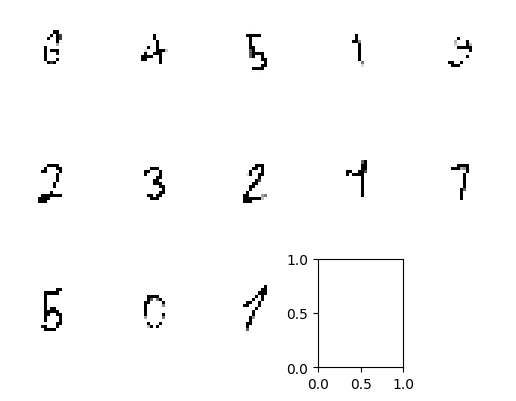

In [14]:
!pip install --upgrade gdown

from os import listdir
import cv2 as cv
import gdown


img_set = list()

digits_dir = f'{getcwd()}/../datasets/digits'
dir_id = '1YehrBNViI4tsiWYA3gcarn9NQ7Sv6LwG'
gdown.download_folder(f'https://drive.google.com/drive/folders/{dir_id}', output=digits_dir, quiet=True)

# Directory containing the list with image files names
images = listdir(digits_dir)

for img in images:

  # Non-image hidden file
  if img != '.ipynb_checkpoints':

    img = cv.imread(f'{digits_dir}/{img}')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Blurs and binarizes the image to possibly remove noisy data (e.g., black dots)
    blurred = cv.GaussianBlur(gray, (37, 37), 0)
    _, binarized = cv.threshold(blurred, 140, 255, cv.THRESH_BINARY)

    # Resizes the image resolution to 28 x 28 (CNN input size fixed)
    resized = cv.resize(binarized, (28, 28), interpolation=cv.INTER_CUBIC)
    img_set.append(resized)

# Raw data from the real images
raw_instances = np.array(img_set)

# Preprocessing
reshaped = raw_instances.reshape(13, 784)
real_test = reshaped.astype('float32') / 255
cnn_test = real_test.reshape(13, 28, 28, 1)

# Predictions
visualize_predictions(cnn_test, 13, 'gray', loaded_model)

# **6. Saving Models**

In [16]:
# Whole dataset for fitting and saving final models
features = np.append(raw_training_attributes, raw_test_attributes)
classes = np.append(raw_training_classes, raw_test_classes)

# Preprocessing
reshaped_features = features.reshape(70000, 784)
training_features = reshaped_features.astype('float32') / 255

cnn_final_features = training_features.reshape(70000, 28, 28, 1)
final_classes = keras.utils.to_categorical(classes, n_classes)

# Can't save model with custom f1 score
dnn_model.compile(loss=lss, optimizer=opt, metrics=['accuracy'])
dnn_model.fit(training_features, final_classes, batch_size=70, epochs=n_epochs, verbose=1)
dnn_model.save(f'{getcwd()}/../models/DNN_{str(n_epochs)}_{str(70)}_{str(actv_funct)}_{str(exit_actv_funct)}_{str(opt)}_{str(lss)}.keras')

cnn_model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
cnn_model.fit(cnn_final_features, final_classes, epochs=n_epochs, batch_size=70)
cnn_model.save(f'{getcwd()}/../models/CNN_{str(n_epochs)}_{str(70)}_{str(actv_funct)}_{str(exit_actv_funct)}_{str(opt)}_{str(lss)}.keras')

Epoch 1/4
1000/1000 [==============================] - 4s 3ms/step - loss: 0.0429 - accuracy: 0.9870
Epoch 2/4
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0275 - accuracy: 0.9917
Epoch 3/4
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0254 - accuracy: 0.9923
Epoch 4/4
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0194 - accuracy: 0.9934
Epoch 1/4
1000/1000 [==============================] - 6s 5ms/step - loss: 0.0285 - accuracy: 0.9909
Epoch 2/4
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0262 - accuracy: 0.9914
Epoch 3/4
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0234 - accuracy: 0.9924
Epoch 4/4
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0224 - accuracy: 0.9928
